/tmp/ipykernel_560657/4221457267.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nom = torch.lgamma(torch.tensor((nu+d)/2))
/tmp/ipykernel_560657/4221457267.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  denom = torch.lgamma(torch.tensor(nu/2)) + d/2 * (np.log(nu) + np.log(np.pi))


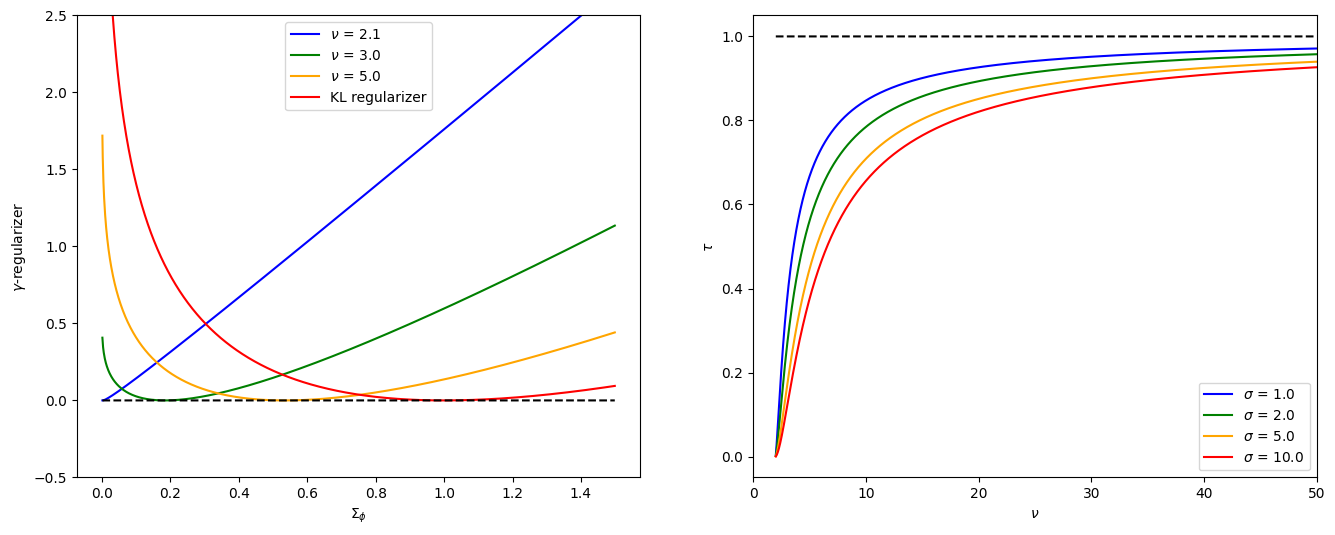

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np

n_dim = m_dim = 1

def log_t_normalizing_const(nu, d):
    nom = torch.lgamma(torch.tensor((nu+d)/2))
    denom = torch.lgamma(torch.tensor(nu/2)) + d/2 * (np.log(nu) + np.log(np.pi))
    return nom - denom

def tau_base(nu, n_dim, sigma) : 
    log_tau_base = -n_dim * np.log(sigma) + log_t_normalizing_const(nu,n_dim) - np.log(nu + n_dim - 2) + np.log(nu-2)
    return torch.exp(log_tau_base/ (nu+n_dim-2))

def tau_generate(nu, n_dim, sigma) : 
    return tau_base(nu, n_dim, sigma) / torch.sqrt(1 + n_dim/nu)

def gamma_regularizer(nu, n_dim, m_dim, recon_sigma, Sigma) : 
    # Sigma = Capital Sigma_phi = sigma_phi^2. 
    if nu == 0 : 
        return Sigma - torch.log(Sigma) - 1
    tau = tau_base(nu, n_dim, recon_sigma).pow(2)

    log_tau_base = -n_dim * np.log(recon_sigma) + log_t_normalizing_const(nu,n_dim) - np.log(nu + n_dim - 2) + np.log(nu-2)
    C_1bar_2 = (1 + m_dim / (nu + n_dim - 2)) * torch.exp(-gamma / (1+gamma) * log_tau_base)

    return nu / (nu+n_dim-2) * Sigma + tau * nu - nu * C_1bar_2 * Sigma.pow(-gamma / 2 / (1+gamma))


fig = plt.figure(figsize = (16,6))
# Sigma vs gamma-regularizer plot
color_list = ['blue', 'green', 'orange', 'red']

ax = fig.add_subplot(1,2,1)
nu_list = [2.1, 3.0, 5.0]
Sigma = torch.tensor(np.arange(1,1500) * 0.001)
recon_sigma = 1

for ind in range(3) : 
    nu = nu_list[ind]
    gamma = -2 / (nu + n_dim + m_dim)
    value = gamma_regularizer(nu, n_dim, m_dim, recon_sigma, Sigma)
    plt.plot(Sigma, value, label = rf'$\nu$ = {nu}', color = color_list[ind])

nu = 0
gamma = -2 / (nu + n_dim + m_dim)
value = gamma_regularizer(nu, n_dim, m_dim, recon_sigma, Sigma)
plt.plot(Sigma, value, label = f'KL regularizer', color = 'red')
plt.plot(Sigma, torch.zeros_like(Sigma), '--', color = 'black')

plt.ylim(-0.5 ,2.5)
# plt.xlabel(r'$\sigma_\phi = \sqrt{\Sigma_\phi}$')
plt.xlabel(r'$\Sigma_\phi$')
plt.ylabel(r'$\gamma$-regularizer')
plt.legend()

ax = fig.add_subplot(1,2,2)
nu = torch.tensor(np.arange(201,5000) * 0.01)
gamma = -2 / (nu + n_dim + m_dim)
recon_sigma_list = [1.0, 2.0, 5.0, 10.0]

for ind in range(4) : 
    recon_sigma = recon_sigma_list[ind]
    tau = tau_generate(nu, n_dim, recon_sigma)
    plt.plot(nu, tau, color=color_list[ind], label = rf'$\sigma$ = {recon_sigma}')
plt.plot(nu, torch.ones_like(nu), '--', color = 'black')
plt.xlim(0, 50)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\tau$')
plt.legend()

plt.savefig('regularizer_revised.png')
plt.show()

